# Use CLIP embeddings to find similar images and to cluster images.
# Uitwerking

- Minor AAI - Hogeschool van Amsterdam
- Docenten:  Michiel Bontenbal & Maarten Post
- Vrijdag 6 september 2024

In this notebook you learn about two applications for cosine similarity: finding similar images and clustering similar images.

First, we'll get an understanding how the maths for cosine similarity work using a basic example.
Next, we'll calculatie the similarity between two images.
Third, we'll find similar images from a set of images. 
And finally, we'll cluster images based on their similarity.

### Contents
1. Intro:  calculate the cosine similarity (nl: cosinusgelijkenis)
2. Calculate cosine similarity for 2 images
3. Find similar images with cosine similarity
4. Clustering images with cosine similarity and KMeans clustering

### Sources
- https://nl.wikipedia.org/wiki/Cosinusgelijkenis
- https://openai.com/research/clip
- https://medium.com/@jeremy-k/unlocking-openai-clip-part-2-image-similarity-bf0224ab5bb0
- https://www.geeksforgeeks.org/how-to-calculate-cosine-similarity-in-python/
- https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/

## 1. Intro:  calculate the cosine similarity (nl: cosinusgelijkenis)

To calculate the cosine similarity we take to vectors (A,B). 
We then calculate their dotproduct and devide it by the product of the normalized vectors. 

cos(θ) = (A · B) / (||A|| ||B||)
)

In [41]:
#Define two points

# Choose values [1-10] (integers/floats) to properly plot it below

# point 1
p1x = 4
p1y = 3

#point 2
p2x = 3
p2y = 4

In [2]:
#function to calculate cosine similarity
def cosine_similarity(a, b):
    dot_product = sum(x * y for x, y in zip(a, b))
    magnitude_a = sum(x * x for x in a) ** 0.5
    magnitude_b = sum(x * x for x in b) ** 0.5
    return dot_product / (magnitude_a * magnitude_b)

cosine_similarity((p1x,p1y), (p2x,p2y))

0.7999999999999998

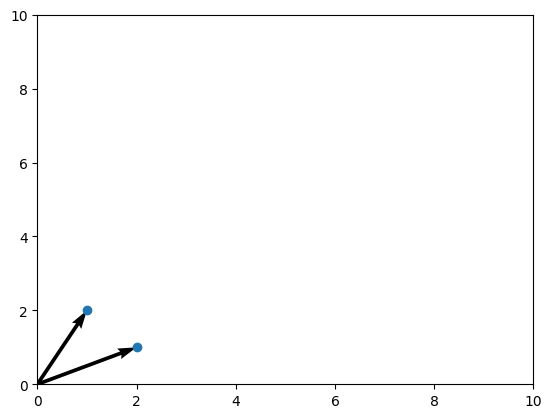

In [3]:
#plot the points and create a vector from 0,0
%matplotlib inline
import matplotlib.pyplot as plt 

#get points and plot them
points_x = p1x, p2x
points_y = p1y, p2y
plt.plot(points_x, points_y, 'o') 

#plot vectors 
plt.quiver([0, 0], [0, 0], [p1x, p2x], [p1y,p2y], angles='xy', scale_units='xy', scale=1)

#plot axes and show it
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

### Exercise 1: 
1. play with the points and see what happens
2. create two examples:
    - Where cosine similarity is 1
    - Where cosine similarity is 0

In [44]:
# Result cosine similarity is 1

# point 1
p1x = 0
p1y = 1

#point 2
p2x = 1
p2y = 0

In [1]:
# Result cosine similarity is 0

# point 1
p1x = 2
p1y = 1

#point 2
p2x = 1
p2y = 2

## 2. Calculate cosine similarity for 2 images

In [46]:
# first install packages! Uncomment if necessary
#%pip install torch torchvision
#%pip install git+https://github.com/openai/CLIP.git

Here we will use two images and calculate how similar they are. 

To do so we'll create embeddings using CLIP. CLIP as several methods of creating embeddings, but here we'll use a standard Vision Transformer (ViT).

In [47]:
# import packages
from PIL import Image
import torch
import torch.nn as nn
import clip

#check device
device = "cuda" if torch.cuda.is_available() else "cpu"

#select embedding model
model, preprocess = clip.load("ViT-B/32", device=device)#we use a Vision Transformer (ViT) for the embeddings

We will download the image dataset from Huggingface. Normally you do this with Hugginface Datasets package, but for now it's easier to clone the dataset as you can easily manually inspect and display the images. 

In [48]:
!git clone https://huggingface.co/datasets/MichielBontenbal/sim_search_mini

fatal: destination path 'sim_search_mini' already exists and is not an empty directory.


In [49]:
ls

2024_09_06_MNIST_CNN_opdracht.ipynb
2024_09_06_MNIST_CNN_uitwerking.ipynb
2024_09_06_image similarity and clustering.ipynb
2024_09_06_image similarity and clustering_uitwerking.ipynb
2024_09_06_ollama_llava_challenges.ipynb
Computer_vision_dag1_2425_sem1.pptx
sim_search_mini/


### TO DO: Manually inspect the images

Open the folder 'sim_search_mini' and take a look at the images

In [50]:
#select two images
image1 = "./sim_search_mini/apple1.jpg"
image2= "./sim_search_mini/apple2.jpg"

In [5]:
#Do preprocessing and create embeddings for the images
image1_preprocess = preprocess(Image.open(image1)).unsqueeze(0).to(device)
image1_features = model.encode_image( image1_preprocess)

image2_preprocess = preprocess(Image.open(image2)).unsqueeze(0).to(device)
image2_features = model.encode_image( image2_preprocess)

NameError: name 'preprocess' is not defined

Inspect the embeddings your created. 
Print it, the number of dimensions and the datatype

In [52]:
#YOUR CODE HERE
print(image1_features)
print(image1_features.ndim)
print(image1_features.dtype)

tensor([[ 5.5165e-02,  5.4966e-01,  4.1985e-03,  1.2056e-01, -3.9534e-01,
         -2.3673e-01, -2.3921e-01,  6.6131e-01,  4.6478e-01,  2.6872e-01,
          2.2077e-03,  4.4410e-01, -8.2033e-01, -1.0280e-01,  8.6644e-02,
         -6.3685e-01,  6.1371e-01,  2.2551e-01,  1.0265e-01, -3.9406e-01,
         -4.1774e-01,  2.0407e-01, -1.4411e-01, -2.9128e-01, -4.0400e-02,
         -1.6912e-01,  2.8970e-01,  2.6217e-02,  5.0442e-02,  5.6924e-03,
          1.3450e-01,  2.4109e-01, -5.3588e-01, -9.0195e-02,  4.6367e-01,
          6.0011e-03, -5.7628e-02, -3.5875e-01, -2.7313e-02,  5.2459e-01,
         -6.0682e-01, -2.3666e-01,  6.0910e-01, -4.0648e-01,  3.5473e-02,
         -1.6132e+00,  7.9045e-01,  7.5812e-02,  2.7101e-01,  2.3142e-01,
          6.4092e-02, -3.2830e-01,  2.3674e-01, -1.2034e-03,  2.5114e-01,
         -4.5010e-01,  3.8673e-01,  1.9133e-01, -2.7579e-01,  9.1605e-03,
          9.7056e-01, -3.1227e-01, -9.2661e-02, -1.2309e-01, -3.3432e-01,
          3.0099e-01,  2.8996e-02,  1.

In [53]:
#calculate the cosine similarity
cos = torch.nn.CosineSimilarity(dim=0)

similarity = cos(image1_features[0],image2_features[0]).item()
similarity = (similarity+1)/2

print("Image similarity: ", similarity)

Image similarity:  0.9985724687576294


## Exercise 2: 
Calculate cosine similarity for images apple1.jpg and elephant1.jpg.  

In [4]:
#Images

#YOUR CODE HERE
image1 = "./sim_search_mini/apple1.jpg"
image2= "./sim_search_mini/elephant1.jpg" 

### Reflect on what you just did:
- How high is the cosine similarity?
- Explain difference between apple/apple and apple/elephant.

apple/apple = 0.98
apple/elephant = 0.73

Elephant does not look like an apple / has very different meaning.

## 3. Find similar images with cosine similarity

In [55]:
import torch
import clip
from PIL import Image
import os
import itertools
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

print(device)

dataset_folder = './sim_search_mini/'

images = []
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith(('jpg','jpeg')):
            images.append(  root  + '/'+ file)


#Embedding of the input image
original_image = './sim_search_mini/face3.jpg'
input_image = preprocess(Image.open(original_image)).unsqueeze(0).to(device) #
input_image_features = model.encode_image(input_image)

result = {}
for img in images:
    with torch.no_grad():
        image_preprocess = preprocess(Image.open(img)).unsqueeze(0).to(device)
        image_features = model.encode_image( image_preprocess)
        cos = torch.nn.CosineSimilarity(dim=0)
        sim = cos(image_features[0],input_image_features[0]).item()
        sim = (sim+1)/2
        result[img]=sim


sorted_value = sorted(result.items(), key=lambda x:x[1], reverse=True)
sorted_res = dict(sorted_value)

top_3 = dict(itertools.islice(sorted_res.items(), 3))

print(top_3)

cpu
{'./sim_search_mini//face3.jpg': 1.0000000596046448, './sim_search_mini//face4.jpg': 0.903565376996994, './sim_search_mini//face5.jpg': 0.8845434188842773}


The original image is:


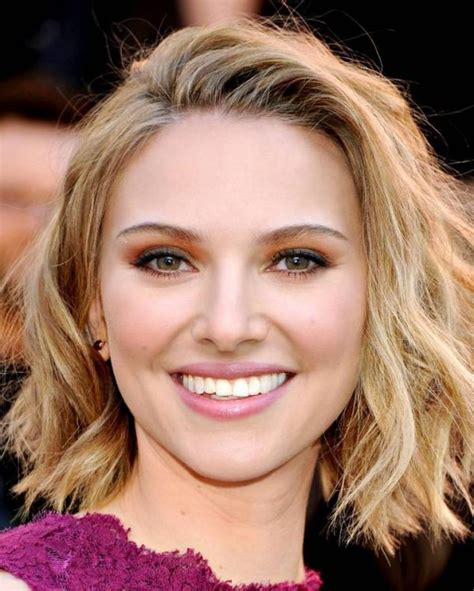

The duplicate is: 


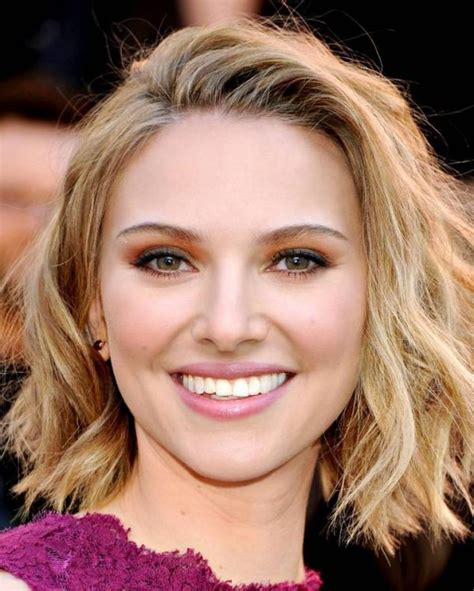

And the most similar images are:


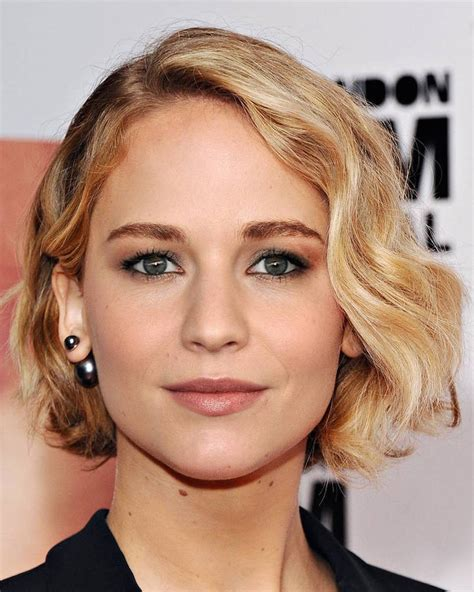

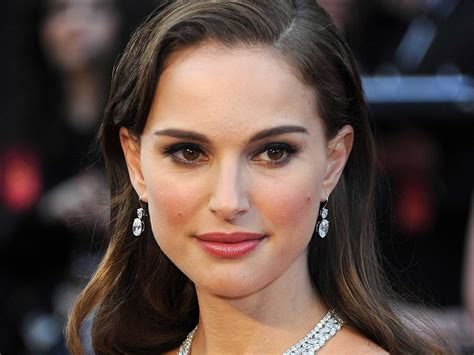

In [56]:
#display most similar images
from IPython.display import Image
from IPython.display import display

original_image = original_image
first = list(top_3.keys())[0]
second = list(top_3.keys())[1]
third = list(top_3.keys())[2]

#original image
img0 = Image(original_image, width = 400) 

#top 3
img1 = Image(first, width = 400) 
img2 = Image(second, width = 400) 
img3 = Image(third, width = 400)

print("The original image is:")
display(img0)
print('The duplicate is: ')
display(img1)
print('And the most similar images are:')
display(img2, img3)

## Exercise 3:
Get the image that is least similar to the original image. 

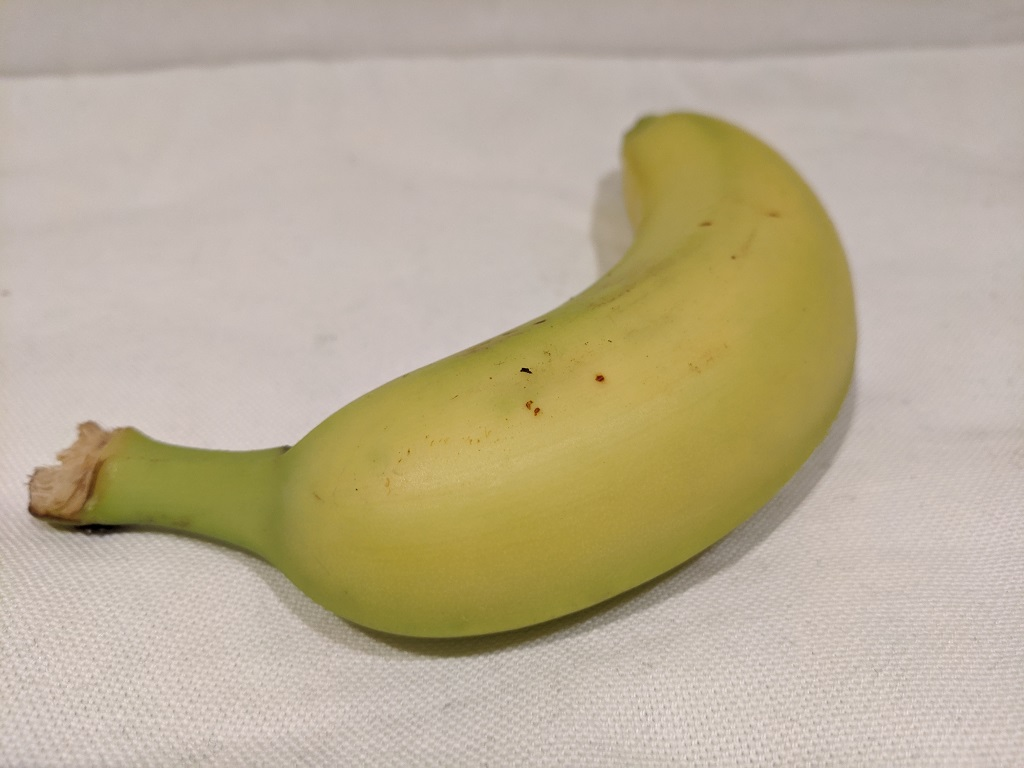

In [57]:
# Select the least similar image and display it

#YOUR CODE HERE
from IPython.display import Image
from IPython.display import display

sorted_res = dict(sorted_value)

last = list(sorted_res.keys())[-1]

img_last = Image(last, width = 400) 
display(img_last)

## 4. Clustering images with cosine similarity and KMeans clustering.

In [58]:
#pip install scikit-learn

In [59]:
#code to ignore warnings
import warnings
warnings.simplefilter('ignore')

In [60]:
#Function to create the embeddings for the images
import torch
from PIL import Image

def get_image_embeddings(image1, image2):
    global embedding1, embedding2
    # Preprocess and encode the first image
    image1_preprocess = preprocess(Image.open(image1)).unsqueeze(0)
    embedding1 = model.encode_image(image1_preprocess)

    # Preprocess and encode the second image
    image2_preprocess = preprocess(Image.open(image2)).unsqueeze(0)
    embedding2 = model.encode_image(image2_preprocess)

    return embedding1, embedding2

In [61]:

#Function to calculate cosine similarity
import torch

def calculate_image_similarity(embedding1, embedding2):
    """
    Calculate the cosine similarity between two sets of image features.
    """
    global similarity
    
    # Create a cosine similarity module
    cos = torch.nn.CosineSimilarity(dim=0)

    # Calculate the cosine similarity between the first features of each image
    similarity = cos(embedding1[0], embedding2[0]).item()

    # Scale the similarity to the range [0, 1]
    similarity = (similarity + 1) / 2
    #print(round(similarity,8))
    return similarity

In [62]:
#select the images you want to use
#images_list = ['./images/apple1.jpg', './images/apple2.jpg', './images/banana1.jpg', './images/banana2.jpg', './images/face1.jpg','./images/face2.jpg']

dataset_folder = './sim_search_mini/'

images_list = []
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith(('jpg','jpeg')):
            images_list.append(  root  + '/'+ file)
images_list

['./sim_search_mini//apple2.jpg',
 './sim_search_mini//apple3.jpg',
 './sim_search_mini//banana5.jpg',
 './sim_search_mini//apple1.jpg',
 './sim_search_mini//banana4.jpg',
 './sim_search_mini//apple4.jpg',
 './sim_search_mini//apple5.jpg',
 './sim_search_mini//banana1.jpg',
 './sim_search_mini//banana3.jpg',
 './sim_search_mini//banana2.jpg',
 './sim_search_mini//orange5.jpg',
 './sim_search_mini//orange4.jpg',
 './sim_search_mini//orange1.jpg',
 './sim_search_mini//orange3.jpg',
 './sim_search_mini//orange2.jpg',
 './sim_search_mini//face1.jpg',
 './sim_search_mini//elephant5.jpg',
 './sim_search_mini//face2.jpg',
 './sim_search_mini//face3.jpg',
 './sim_search_mini//elephant4.jpg',
 './sim_search_mini//elephant1.jpg',
 './sim_search_mini//elephant3.jpg',
 './sim_search_mini//face4.jpg',
 './sim_search_mini//face5.jpg',
 './sim_search_mini//elephant2.jpg']

In [63]:
#calculate the cosine similarity to each image in the list. This may take some time like 2 min or longer.
cos_sim_list =[]
for i in range(len(images_list)):
    image1 = images_list[i]
    for j in range(len(images_list)):
        image2 = images_list[j]
        get_image_embeddings(image1, image2)
        calculate_image_similarity(embedding1, embedding2)
        cos_sim_list.append(similarity)

print(cos_sim_list)


[1.0, 0.9708459973335266, 0.9125018417835236, 0.9985724687576294, 0.8616221845149994, 0.9900812208652496, 0.9599809050559998, 0.9068856835365295, 0.8611359596252441, 0.9012599587440491, 0.9021157026290894, 0.9214508533477783, 0.8874039053916931, 0.9092331826686859, 0.8941128551959991, 0.7165658324956894, 0.7390061318874359, 0.7252222001552582, 0.6767897307872772, 0.7528432905673981, 0.7409431636333466, 0.7521595060825348, 0.6961556822061539, 0.6967225521802902, 0.7258834093809128, 0.9708459973335266, 1.0000000596046448, 0.9168405532836914, 0.9738948345184326, 0.8813419044017792, 0.9803316593170166, 0.9721458554267883, 0.9097655713558197, 0.8820505738258362, 0.919611006975174, 0.9136277139186859, 0.9372277855873108, 0.9020981192588806, 0.9266842007637024, 0.9091777801513672, 0.7039288431406021, 0.7394101619720459, 0.7281582653522491, 0.6728980392217636, 0.7594129741191864, 0.7393767982721329, 0.7570022940635681, 0.6917192190885544, 0.6969428658485413, 0.7308960407972336, 0.9125018417835

In [64]:
#convert this list to a numpy array
import numpy as np
num_rows = len(images_list)
cosine_similarity_matrix = np.array(cos_sim_list).reshape(num_rows, -1)
cosine_similarity_matrix

array([[1.        , 0.970846  , 0.91250184, 0.99857247, 0.86162218,
        0.99008122, 0.95998091, 0.90688568, 0.86113596, 0.90125996,
        0.9021157 , 0.92145085, 0.88740391, 0.90923318, 0.89411286,
        0.71656583, 0.73900613, 0.7252222 , 0.67678973, 0.75284329,
        0.74094316, 0.75215951, 0.69615568, 0.69672255, 0.72588341],
       [0.970846  , 1.00000006, 0.91684055, 0.97389483, 0.8813419 ,
        0.98033166, 0.97214586, 0.90976557, 0.88205057, 0.91961101,
        0.91362771, 0.93722779, 0.90209812, 0.9266842 , 0.90917778,
        0.70392884, 0.73941016, 0.72815827, 0.67289804, 0.75941297,
        0.7393768 , 0.75700229, 0.69171922, 0.69694287, 0.73089604],
       [0.91250184, 0.91684055, 0.99999997, 0.91367647, 0.93942285,
        0.91217339, 0.90852001, 0.98652437, 0.93421495, 0.97348917,
        0.91053012, 0.90779796, 0.90046376, 0.90484852, 0.90256798,
        0.70437895, 0.76012215, 0.74925373, 0.67676568, 0.76104963,
        0.75831121, 0.77379432, 0.6917941 , 0.

In [65]:
## Exercise 4
For KMeans you'll have to set the number of clusters manuall. 
Do so in the code below by replacing the question mark. 

Answer = 5

SyntaxError: unterminated string literal (detected at line 2) (1911050595.py, line 2)

Image 0 is in cluster 0
Image 1 is in cluster 0
Image 2 is in cluster 4
Image 3 is in cluster 0
Image 4 is in cluster 4
Image 5 is in cluster 0
Image 6 is in cluster 0
Image 7 is in cluster 4
Image 8 is in cluster 4
Image 9 is in cluster 4
Image 10 is in cluster 3
Image 11 is in cluster 3
Image 12 is in cluster 3
Image 13 is in cluster 3
Image 14 is in cluster 3
Image 15 is in cluster 1
Image 16 is in cluster 2
Image 17 is in cluster 1
Image 18 is in cluster 1
Image 19 is in cluster 2
Image 20 is in cluster 2
Image 21 is in cluster 2
Image 22 is in cluster 1
Image 23 is in cluster 1
Image 24 is in cluster 2


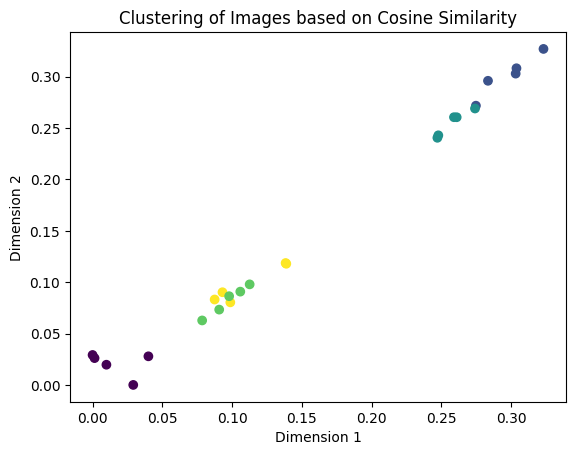

In [ ]:
# Do the clustering with the K-Means algo and show it using Matplotlib. 
# Warning: this is a little different because we do clustering based on 1 Dimension (instead of 2 or more)
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Convert cosine similarity to distance (1 - similarity)
distance_matrix = 1 - cosine_similarity_matrix

# Choose the number of clusters (k)
num_clusters = 5

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(distance_matrix)

# Get cluster labels
labels = kmeans.labels_

# Print the cluster assignments
for i, label in enumerate(labels):
    print(f"Image {i} is in cluster {label}")

# Optional: Visualize the clustering result
# Here we assume you have 2D data, for visualization purposes only
plt.scatter(distance_matrix[:, 0], distance_matrix[:, 1], c=labels)
plt.title('Clustering of Images based on Cosine Similarity')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
#create a result list and merge it with the images_list to check your result manually
result_list = []
for i, label in enumerate(labels):
    #print(f"Image {i} is in cluster {label}")
    result_list.append(label)
result_list

# Merge the lists into a dictionary
merged_dict = dict(zip(images_list, result_list))

# Print the resulting dictionary
print(merged_dict)

{'./sim_search_mini//apple2.jpg': 0, './sim_search_mini//apple3.jpg': 0, './sim_search_mini//banana5.jpg': 4, './sim_search_mini//apple1.jpg': 0, './sim_search_mini//banana4.jpg': 4, './sim_search_mini//apple4.jpg': 0, './sim_search_mini//apple5.jpg': 0, './sim_search_mini//banana1.jpg': 4, './sim_search_mini//banana3.jpg': 4, './sim_search_mini//banana2.jpg': 4, './sim_search_mini//orange5.jpg': 3, './sim_search_mini//orange4.jpg': 3, './sim_search_mini//orange1.jpg': 3, './sim_search_mini//orange3.jpg': 3, './sim_search_mini//orange2.jpg': 3, './sim_search_mini//face1.jpg': 1, './sim_search_mini//elephant5.jpg': 2, './sim_search_mini//face2.jpg': 1, './sim_search_mini//face3.jpg': 1, './sim_search_mini//elephant4.jpg': 2, './sim_search_mini//elephant1.jpg': 2, './sim_search_mini//elephant3.jpg': 2, './sim_search_mini//face4.jpg': 1, './sim_search_mini//face5.jpg': 1, './sim_search_mini//elephant2.jpg': 2}


## Conclusion
We've succesfully clustered a set of diverse images. To achieve this, we have calculated the cosine similartity for each image to the others. We've used a standerd KMeans clustering algorith to cluster the images and used Matplotlib to plot the results.

### Reflection questions

#### 1. Write down the steps you did to get to the clustering in your own words.
- Step 1: Download images
- Step 2: Create image embeddings
- Step 3: Calculate cosine similarity between all embeddings
- Step 4: Create 5 clusters, run the KMeans algorithm.

#### 2. Describe an embedding in your own words
A numerical representation of an image in a datatype called a vector.


#### 3: Hard question. How can we speed up the calculation of the cosine similarity?
Hint: check the datatype of the embedding. 
Current datatype of embeddding is FloatingPoint32. If we convert to FP16 or INT8 we lose some quality, but gain a lot of speed.


